![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Running LISFLOOD model using eWaterCycle package (on Cartesius machine of SURFsara)

This notebooks shows how to run [LISFLOOD](https://ec-jrc.github.io/lisflood-model/) model. Please note that the [lisflood-grpc4bmi docker image](https://hub.docker.com/r/ewatercycle/lisflood-grpc4bmi) in eWaterCycle is compatible only with forcing data and parameter set on [eWaterCycle infrastructure](https://github.com/eWaterCycle/infra) like a server on the SURF Research Cloud. More information about data, configuration and installation instructions can be found in the [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) in the eWaterCycle documentation.

In [1]:
import logging
import warnings

logger = logging.getLogger("grpc4bmi")
logger.setLevel(logging.WARNING)

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

## Load forcing data

For this example notebook, `lisflood_ERA-Interim_*_1990_1990.nc` data are copied 
from `/projects/0/wtrcycle/comparison/forcing/lisflood` to `/scratch/shared/ewatercycle/lisflood_example/lisflood_forcing_data`.
Also the lisvap output files 'e0', 'es0' and 'et0' are generated and stored in the same directory.
These data are made by running ESMValTool recipe and lisvap. We can now use those files to run the Lisflood model.

In [3]:
forcing = ewatercycle.forcing.load_foreign(
    target_model="lisflood",
    directory="/mnt/data/forcing/lisflood_ERA5_1990_global-masked",
    start_time="1990-01-01T00:00:00Z",
    end_time="1990-12-31T00:00:00Z",
    forcing_info={
        "PrefixPrecipitation": "lisflood_ERA5_pr_1990_1990.nc",
        "PrefixTavg": "lisflood_ERA5_tas_1990_1990.nc",
        "PrefixE0": "lisflood_ERA5_e0_1990_1990.nc",
        "PrefixES0": "lisflood_ERA5_es0_1990_1990.nc",
        "PrefixET0": "lisflood_ERA5_et0_1990_1990.nc",
    },
)
print(forcing)

eWaterCycle forcing
-------------------
start_time=1990-01-01T00:00:00Z
end_time=1990-12-31T00:00:00Z
directory=/mnt/data/forcing/lisflood_ERA5_1990_global-masked
shape=None
PrefixPrecipitation=lisflood_ERA5_pr_1990_1990.nc
PrefixTavg=lisflood_ERA5_tas_1990_1990.nc
PrefixE0=lisflood_ERA5_e0_1990_1990.nc
PrefixES0=lisflood_ERA5_es0_1990_1990.nc
PrefixET0=lisflood_ERA5_et0_1990_1990.nc


## Load parameter set

This example uses parameter set on Cartesius machine of SURFsara.

In [4]:
parameterset = ewatercycle.parameter_sets.ParameterSet(
    name="Lisflood01degree_masked",
    directory="/mnt/data/parameter-sets/lisflood_global-masked_01degree",
    config="/mnt/data/parameter-sets/lisflood_global-masked_01degree/settings_lisflood_ERA5.xml",
    target_model="lisflood",
)
print(parameterset)

Parameter set
-------------
name=Lisflood01degree_masked
directory=/mnt/data/parameter-sets/lisflood_global-masked_01degree
config=/mnt/data/parameter-sets/lisflood_global-masked_01degree/settings_lisflood_ERA5.xml
doi=N/A
target_model=lisflood
supported_model_versions=set()


## Set up the model

To create the model object, we need to select a version.

In [5]:
ewatercycle.models.Lisflood.available_versions

('20.10',)

In [6]:
model = ewatercycle.models.Lisflood(
    version="20.10", parameter_set=parameterset, forcing=forcing
)
print(model)

Model version 20.10 is not explicitly listed in the supported model versions of this parameter set. This can lead to compatibility issues.
eWaterCycle Lisflood
-------------------
Version = 20.10
Parameter set = 
  Parameter set
  -------------
  name=Lisflood01degree_masked
  directory=/mnt/data/parameter-sets/lisflood_global-masked_01degree
  config=/mnt/data/parameter-sets/lisflood_global-masked_01degree/settings_lisflood_ERA5.xml
  doi=N/A
  target_model=lisflood
  supported_model_versions=set()
Forcing = 
  eWaterCycle forcing
  -------------------
  start_time=1990-01-01T00:00:00Z
  end_time=1990-12-31T00:00:00Z
  directory=/mnt/data/forcing/lisflood_ERA5_1990_global-masked
  shape=None
  PrefixPrecipitation=lisflood_ERA5_pr_1990_1990.nc
  PrefixTavg=lisflood_ERA5_tas_1990_1990.nc
  PrefixE0=lisflood_ERA5_e0_1990_1990.nc
  PrefixES0=lisflood_ERA5_es0_1990_1990.nc
  PrefixET0=lisflood_ERA5_et0_1990_1990.nc


In [7]:
model.parameters

[('IrrigationEfficiency', '0.75'),
 ('MaskMap', '/data/input/areamaps/model_mask'),
 ('start_time', '1990-01-01T00:00:00Z'),
 ('end_time', '1990-12-31T00:00:00Z')]

Setup model with model_mask, IrrigationEfficiency of 0.8 instead of 0.75 and an earlier end time, making total model time just 1 month.

In [8]:
model_mask = "/mnt/data/climate-data/aux/LISFLOOD/model_mask.nc"

config_file, config_dir = model.setup(
    IrrigationEfficiency="0.8", end_time="1990-1-31T00:00:00Z", MaskMap=model_mask
)
print(config_file)
print(config_dir)

Running /mnt/data/singularity-images/ewatercycle-lisflood-grpc4bmi_20.10.sif singularity container on port 41619
/home/vagrant/ewatercycle/docs/examples/ewatercycle_output/lisflood_20210930_093520/lisflood_setting.xml
/home/vagrant/ewatercycle/docs/examples/ewatercycle_output/lisflood_20210930_093520


In [9]:
model.parameters

[('IrrigationEfficiency', '0.8'),
 ('MaskMap', '/mnt/data/climate-data/aux/LISFLOOD/model_mask'),
 ('start_time', '1990-01-01T00:00:00Z'),
 ('end_time', '1990-01-31T00:00:00Z')]

Initialize the model with the config file:

In [10]:
model.initialize(config_file)

Get model variable names

In [11]:
model.output_var_names

('Discharge',)

## Run the model

Store simulated values at one target location until model end time. In this example, we use the coordinates of Merrimack observation station as the target coordinates. 

In [12]:
target_longitude = [-71.35]
target_latitude = [42.64]
target_discharge = []
time_range = []
end_time = model.end_time

while model.time < end_time:
    model.update()
    target_discharge.append(
        model.get_value_at_coords(
            "Discharge", lon=target_longitude, lat=target_latitude
        )[0]
    )
    time_range.append(model.time_as_datetime.date())
    print(model.time_as_isostr)

1990-01-03T00:00:00Z
1990-01-04T00:00:00Z
1990-01-05T00:00:00Z
1990-01-06T00:00:00Z
1990-01-07T00:00:00Z
1990-01-08T00:00:00Z
1990-01-09T00:00:00Z
1990-01-10T00:00:00Z
1990-01-11T00:00:00Z
1990-01-12T00:00:00Z
1990-01-13T00:00:00Z
1990-01-14T00:00:00Z
1990-01-15T00:00:00Z
1990-01-16T00:00:00Z
1990-01-17T00:00:00Z
1990-01-18T00:00:00Z
1990-01-19T00:00:00Z
1990-01-20T00:00:00Z
1990-01-21T00:00:00Z
1990-01-22T00:00:00Z
1990-01-23T00:00:00Z
1990-01-24T00:00:00Z
1990-01-25T00:00:00Z
1990-01-26T00:00:00Z
1990-01-27T00:00:00Z
1990-01-28T00:00:00Z
1990-01-29T00:00:00Z
1990-01-30T00:00:00Z
1990-01-31T00:00:00Z


Store simulated values for all locations of the model grid at end time.

In [13]:
discharge = model.get_value_as_xarray("Discharge")

In [14]:
model.finalize()

## Inspect the results

The discharge time series at Merrimack observation station:

<AxesSubplot:>

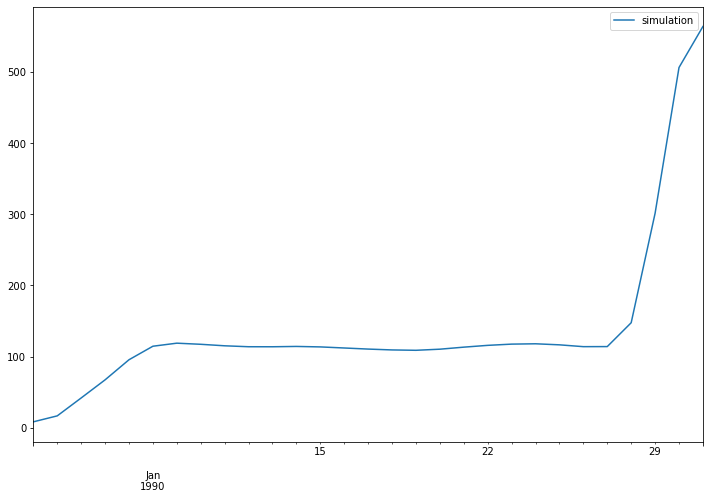

In [15]:
simulated_target_discharge = pd.DataFrame(
    {"simulation": target_discharge}, index=pd.to_datetime(time_range)
)
simulated_target_discharge.plot(figsize=(12, 8))

The lisflood output has a global extent. In this example, we plot the discharge values in Merrimack catchment and at the last time step.

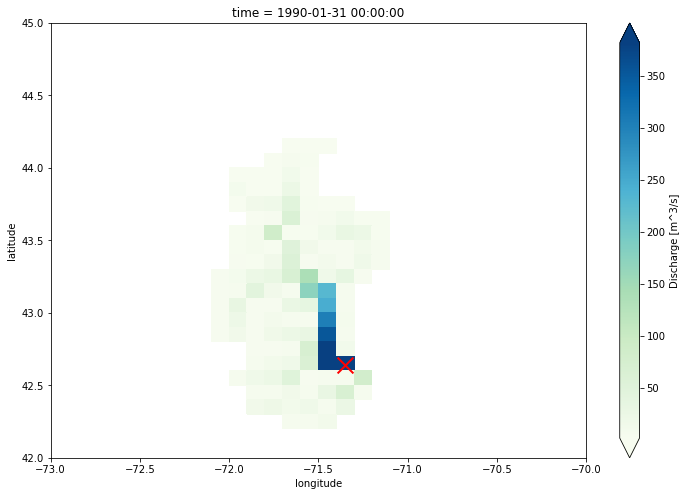

In [16]:
lc = discharge.coords["longitude"]
la = discharge.coords["latitude"]
discharge_map = discharge.loc[
    dict(longitude=lc[(lc > -73) & (lc < -70)], latitude=la[(la > 42) & (la < 45)])
].plot(robust=True, cmap="GnBu", figsize=(12, 8))
discharge_map.axes.scatter(
    target_longitude, target_latitude, s=250, c="r", marker="x", lw=2
)